In [1]:
import cupy as cp
import numpy as np
import time

%load_ext autoreload
%autoreload 2

In [ ]:
### Numpy and CPU
s = time.time()
x_cpu = np.ones((4000,100,1))
e = time.time()
print(e - s)

In [ ]:
### CuPy and GPU
s = time.time()
x_gpu = cp.ones((4000,1))
cp.cuda.Stream.null.synchronize()
e = time.time()
print(e - s)

In [2]:
import math
from bprH_gpu import bprH, adv_index, save_model, load_model
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import cProfile as profile

In [3]:
def behavior_generator(num_user = 10, num_item=10):
    data = []
    for u in range(num_user):
        for i in range(num_item):
            p = np.random.uniform(0,1)
            if 0.7 <= p:
                data.append(['U' + str(u),'I' + str(i),'P'])
                data.append(['U' + str(u),'I' + str(i),'V'])
            elif 0.3 <= p:
                data.append(['U' + str(u),'I' + str(i),'V'])
    data = pd.DataFrame(data, columns=['UserID', 'ItemID', 'Action'])
    return data

In [4]:
data = behavior_generator(num_user=50, num_item=50)

In [5]:
# the best way is to split the data with a time manner - from sklearn.model_selection import TimeSeriesSplit
# but first let's do it in a simple way

original_item_list = sorted(set(data.ItemID))
original_user_list = sorted(set(data.UserID))

data_without_target = data[data.Action != 'P']
data_only_with_target = data[data.Action == 'P']

In [6]:
# split the data_only_with_target into 5 folds
#kf = KFold(n_splits=5,shuffle=True, random_state=0)
#kf.get_n_splits(X=data_only_with_target)

d1, test_data = train_test_split(data_only_with_target, test_size=0.2)

train_data = pd.concat([d1, data_without_target])
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

  0%|          | 21/9000 [00:10<1:17:12,  1.94it/s, auc=0, loss=-2.8906038193454484, norm_nabula_U_u=4.01467845355751, norm_nabula_Vi=0.0273, norm_nabula_Vj=0.0258, norm_nabula_Vk=0.0211, precision_10=0.083, precision_5=0.0638, recall_10=0.249, recall_5=0.105]


KeyboardInterrupt: 

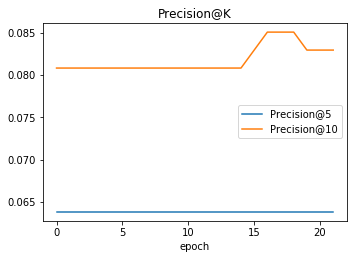

In [10]:
model = bprH(dim=5,
                 omega=10,
                 rho=1,
                 lambda_u=0.5,
                 lambda_v=0.1,
                 lambda_b=0.1,
                 gamma=0.1,
                 random_state=20200704,
                 num_iter=9000)

model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-test.pkl',
              coselection=True,
              plot_metric=True)

In [ ]:
kf = KFold(n_splits=5,shuffle=True, random_state=0)
kf.get_n_splits(X=data_only_with_target)

cnt = 0
for train_index, test_index in kf.split(X=data_only_with_target):
    # build train and test data
    # page 90 5.2 section - make most of auxiliary data in training process
    train_data = pd.concat([data_only_with_target.iloc[train_index], data_without_target])
    test_data = data_only_with_target.iloc[test_index]

    # start a BPRH model
    model = bprH(dim=8,
                 omega=1,
                 rho=1,
                 lambda_u=1.5,
                 lambda_v=0.1,
                 lambda_b=0.1,
                 gamma=0.01,
                 random_state=20200704,
                 num_iter=9000)

    model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-'+str(cnt)+'.pkl',
              coselection=True,
              plot_metric=True)
    cnt += 1


In [3]:
# read sobazaar data
data = pd.read_csv('data/sb_unique_actions_20.csv')
# change column name
data.columns = ['ItemID', 'UserID', 'Action', 'Action_Date', 'Action_Time',
       'SessionID']

# data = data.sample(frac=0.5) # TODO: test small data

In [4]:
# the best way is to split the data with a time manner - from sklearn.model_selection import TimeSeriesSplit
# but first let's do it in a simple way

original_item_list = sorted(set(data.ItemID))
original_user_list = sorted(set(data.UserID))

data_without_target = data[data.Action != 'P']
data_only_with_target = data[data.Action == 'P']

In [ ]:
# split the data_only_with_target into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X=data_only_with_target)

In [ ]:
cnt = 0
for train_index, test_index in kf.split(X=data_only_with_target):
    # build train and test data
    train_data = pd.concat([data_only_with_target.iloc[train_index], data_without_target])
    test_data = data_only_with_target.iloc[test_index]

    # start a BPRH model
    model = bprH(dim=30,
                 omega=1000,
                 rho=1,
                 lambda_u=1,
                 lambda_v=0.5,
                 lambda_b=0.5,
                 gamma=0.01,
                 random_state=20200704,
                 num_iter=10000)

    model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-'+str(cnt)+'.pkl',
              coselection=True,
              plot_metric=True)
    cnt += 1

In [5]:
d1, test_data = train_test_split(data_only_with_target, test_size=0.2)

train_data = pd.concat([d1, data_without_target])
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

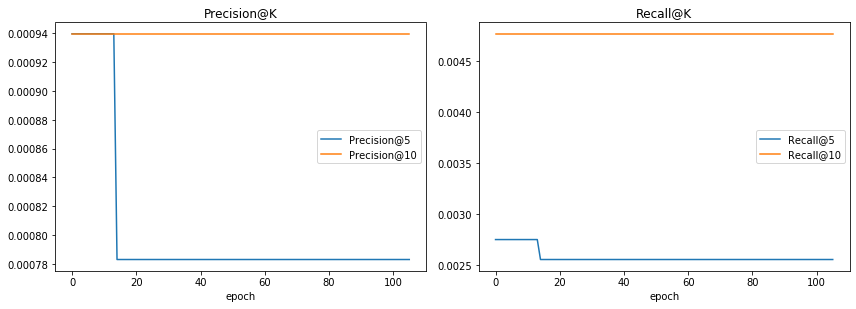

  1%|          | 106/10000 [03:39<5:18:38,  1.93s/it, auc=0, loss=[-9.21914654], norm_nabula_U_u=9.535955399603981, norm_nabula_Vi=1.44, norm_nabula_Vj=5.51, norm_nabula_Vk=0, precision_10=0.00094, precision_5=0.000783, recall_10=0.00477, recall_5=0.00255]

Precision@K
	Precision@5      	 (min:    0.001, max:    0.001, cur:    0.001)
	Precision@10     	 (min:    0.001, max:    0.001, cur:    0.001)
Recall@K
	Recall@5         	 (min:    0.003, max:    0.003, cur:    0.003)
	Recall@10        	 (min:    0.005, max:    0.005, cur:    0.005)


In [ ]:
#pr = profile.Profile()
#pr.enable()

model = bprH(dim=50,
                 omega=300,
                 rho=1,
                 lambda_u=0.5,
                 lambda_v=0.1,
                 lambda_b=0.1,
                 gamma=0.1,
                 random_state=20200704,
                 num_iter=10000)

model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-test.pkl',
              coselection=True,
              plot_metric=True)

#pr.disable()
#pr.dump_stats("bhrH_gpu_profile.pstat")